# Measuring Empowerment and Plasticity

## 1. Bit World

## 2. Light Rooms (from the paper)

## 3. Next Steps
* Empirically measure the "conservation law" that I am still not convinced by.
* Write an Algorithm for estimating GDI

---

## Appendix: Implementing functions from Information Theory

### A. Discrete Random Variables (DRVs)
I haven't formally worked with information theory before, so I started off by implementing some of the basic information theoretic quantities like entropy, joint entropy, conditional entropy and mutual information for just _discrete random variables_ with a tiny alphabet. Namely,

$$ X, Y \sim \text{Bernoulli}(0.5),$$

i.e. two coin tosses :D

Sample Sizes:   0%|          | 0/9 [00:00<?, ?it/s]

Sample Sizes: 100%|██████████| 9/9 [00:00<00:00, 689.93it/s]


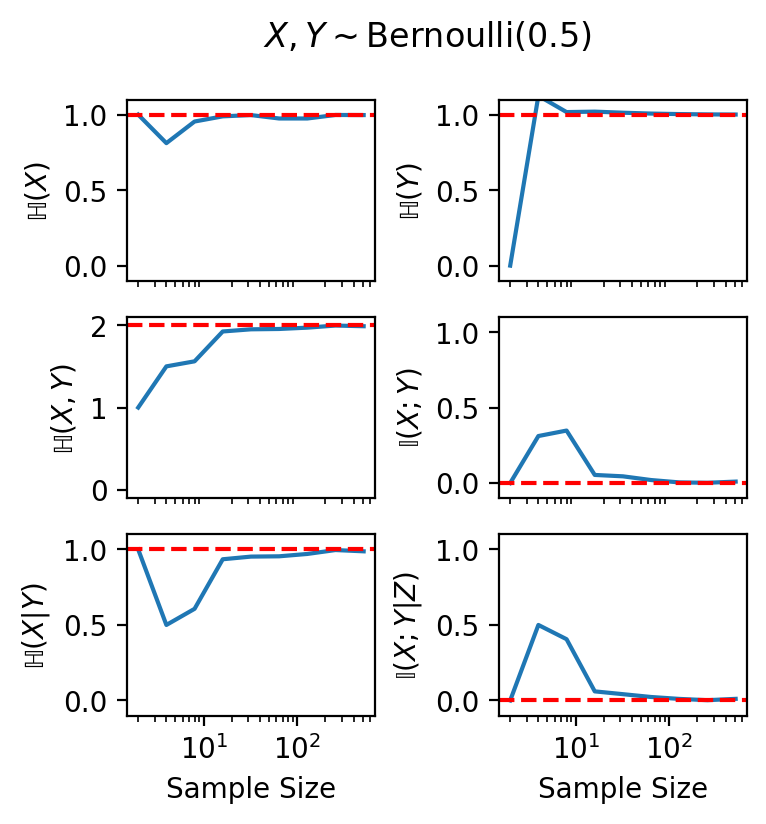

In [2]:
from experiments.it_diagnostic import drv_quantities
drv_quantities()

### B. Sequences of DRVs

Next, I moved on to sequences of discrete random variables. Initially I naively tried scaling up the same numerical methods from the single DRV setting:
1. Rollout a sequence of 100 coin tosses ($X^{100}$)
2. Do this a 1000 times to get 1000 samples of $X^{100}$ as our dataset $\mathcal{D}$
3. Compute $\text{Pr}(X^n)$ in a frequentist manner
4. Plug $\text{Pr}(X^n)$ into the entropy formula $\mathbb{H}(X^{100}) = - \sum_{X^{100} \in \mathcal{D}} \text{Pr}(X^{100}) \log_2(\text{Pr}(X^{100}))$

The problem here is that the space of all possible $X^{100}$ is HUGE (of size $2^{100}$ for the Bernoulli sequences I was working with)! So all sequences in $\mathcal{D}$ were unique, and $\text{Pr}(X^{100})$ always looked like a uniform distribution, with entropy = $\log_2(1000) \approx 10 \, \text{bits}$.

So as I plotted this incorrect entropy as a function of $\log(\text{sample size})$, it went up linearly, instead of converging :`).

<img src="images/NaiveEntropySeq.png" alt="Incorrect entropy went up linearly with sample size :(" width="50%">

Side notes:
* Initially I tried using this undersampled entropy estimator straight away in the `LightRooms` env, but saw both plasticity and empowerment go up when a random agent entered rooms it could control better. This is when I knew there was a bug in my sequences code.
* I did find a less biased estimator of entropy than $\mathbb{H}(X) = - \sum_{X \in \mathcal{X}} \text{Pr}(X) \log_2(\text{Pr}(X))$ (sometimes called the Maximum Liklihood Estimator of entropy), by adding a correction term called the _Miller-Madow correction_. This did help in the discerete random variable setting, but the undersampling error in the discrete random sequence setting was just too huge to fix with this term.

I was able to fix this using conditional entropies. Specifically, instead of trying to estimate a single 100-dimensional joint probability distribution, I tried estimating a 100 one-dimensional conditional probability distributions. Since,
$$
\begin{align*}
\text{Pr}(X^n) &= \text{Pr}(X_1, \dots, X_n)\\
&= \text{Pr}(X_1) \times \text{Pr}(X_2|X_1) \times \text{Pr}(X_3|X_1, X_2) \times \dots \text{Pr}(X_n|X_1,\dots X_{n-1})\\
&= \prod_{k=1}^n \text{Pr}(X_k | X^{k-1}).
\end{align*}
$$

Where I use a short hand of $X^{k-1} = [X_1 \dots X_{k-1}]$. Plugging this into the definition of entropy, we get:
$$
\begin{align*}
\mathbb{H}(X^n) &= -\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \log\big(\text{Pr}(X^n)\big),\\
&= -\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \log\Bigg(\prod_{k=1}^n \text{Pr}(X_k | X^{k-1})\Bigg)\\
&= -\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \sum_{k=1}^n\log\big(\text{Pr}(X_k | X^{k-1})\big)\\
&= -\sum_{k=1}^n\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \log\big(\text{Pr}(X_k | X^{k-1})\big)\\
&= \sum_{k=1}^n \mathbb{H}(X_k | X^{k-1}).\\
\end{align*}
$$

We arrive at the last line by the defintion of conditonal entropy, $\mathbb{H}(X|Y) = -\sum_{\mathcal{X, Y}} \text{Pr}(X, Y) \log(\text{Pr}(X|Y))$. In the codebase, `mi.conditional_entropy_from_context()` computes each term of this summation, without ever having to estimate a multi-dimensional probability distribution 🎉. We plot these for our sequences of Bernoulli(0.5) variables:

<img src="images/CorrectEntropySeq.png" alt="Entropy converges to the correct number of bits" width="50%">

I _think_ this is what's normally done in the field to estimate the entropy of a sequence.

### C. Directed Information: Why & How I approximate it